# Analysis of historic Irish weather

## Author: Joanna Mnich

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def clean_station(file_path, output_path):
    """
    Clean a Met Éireann station CSV and save year, month, wdsp (mean wind speed).
    
    Args:
        file_path (str): path to raw CSV
        output_path (str): path to save cleaned CSV
    """

# Detect first row with actual numeric data (starts with a year)
    data_row = None
    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            # skip empty lines, look for line starting with a digit (year)
            if line.strip() and line.strip()[0].isdigit():
                data_row = i
                break

    if data_row is None:
        print(f"No data found in {file_path}")
        return

# Read CSV from detected data row
    df = pd.read_csv(
        file_path,
        skiprows=data_row,
        header=None,
        na_values=["---", "NaN"],
        on_bad_lines="skip"
    )

# Assign proper column names (based on Met Éireann standard)
    col_names = [
        "year","month","meant","maxtp","mintp","mnmax",
        "mnmin","rain","gmin","wdsp","maxgt","sun"
    ][:df.shape[1]]  # adjust if file has fewer columns
    df.columns = col_names
    
# Keep only relevant columns
    df = df[["year", "month", "wdsp"]]

# Convert to numeric (coerce errors)
    for col in ["year", "month", "wdsp"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter years 2005–2025 and remove missing wdsp
    df = df.dropna(subset=["wdsp"])
    df = df[(df["year"] >= 2005) & (df["year"] <= 2025)]

# Save cleaned CSV
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} — rows: {len(df)}")


In [4]:
stations = {
    "Malin_Head": "Malin_Head.csv",
    "Roches_Point": "Roches_point.csv",
    "Sherkin_Island": "SherkinIsland.csv",
    "Valentia_Observatory": "Valentia_Observatory.csv",
    "Dublin_Airport": "Dublin_Airport.csv",
    "Mt_Dillon": "Mt_Dillon.csv",
    "Casement_Aerodrome": "Casement_Aerodrome.csv",
    "Belmullet": "Belmullet.csv",
    "Mullingar": "Mullingar.csv",
    "Claremorris": "Claremorris.csv"
}

for station, filename in stations.items():
    clean_station(
        file_path=f"data/raw/{filename}",
        output_path=f"data/processed/{station}_cleaned.csv"
    )


Saved data/processed/Malin_Head_cleaned.csv — rows: 250
Saved data/processed/Roches_Point_cleaned.csv — rows: 249
Saved data/processed/Sherkin_Island_cleaned.csv — rows: 249
Saved data/processed/Valentia_Observatory_cleaned.csv — rows: 249
Saved data/processed/Dublin_Airport_cleaned.csv — rows: 251
Saved data/processed/Mt_Dillon_cleaned.csv — rows: 247
Saved data/processed/Casement_Aerodrome_cleaned.csv — rows: 251
Saved data/processed/Belmullet_cleaned.csv — rows: 246
Saved data/processed/Mullingar_cleaned.csv — rows: 251
Saved data/processed/Claremorris_cleaned.csv — rows: 243


### Analyse mean wind speed from merged station script

In [5]:
# Load merged cleaned data
df = pd.read_csv("data/processed/all_stations_cleaned.csv")

# Safety check (remove any accidental master rows)
df = df[df["station"] != "ALL_STATIONS"]

df.head()

mean_wind_station = (
    df.groupby("station")["wdsp"]
      .mean()
      .sort_values(ascending=False)
)

mean_wind_station


station
Malin_Head              14.628400
Sherkin_Island          12.345783
Roches_Point            12.118072
Belmullet               11.711382
Dublin_Airport          10.206375
Casement_Aerodrome       9.704382
Valentia_Observatory     9.306426
Claremorris              7.949383
Mt_Dillon                7.008097
Mullingar                6.158566
Name: wdsp, dtype: float64

In [ ]:
# Wind speed range statistics by station
wind_range_station = df.groupby("station")["wdsp"].agg(["mean", "min", "max", "std"])
wind_range_station.sort_values("mean", ascending=False)


,mean,min,max,std
station,,,,
Malin_Head,14.628400,7.8,22.3,2.896937
Sherkin_Island,12.345783,7.8,21.5,2.568464
Roches_Point,12.118072,8.0,19.2,2.062148
Belmullet,11.711382,6.4,18.9,2.224766
Dublin_Airport,10.206375,6.5,16.3,1.892923
Casement_Aerodrome,9.704382,5.7,16.3,2.093481
Valentia_Observatory,9.306426,5.3,17.2,2.029391
Claremorris,7.949383,4.8,12.1,1.192933
Mt_Dillon,7.008097,3.9,12.0,1.333624


### Monthly average wind speed plot for each station

In [ ]:
for station in stations.keys():
    df = pd.read_csv(f"data/processed/{station}_cleaned.csv")
    monthly_avg = df.groupby("month")["wdsp"].mean()

    plt.figure()
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
    plt.title(f"Average Monthly Wind Speed at {station.replace('_', ' ')} (2005-2025)")
    plt.xlabel("Month")
    plt.ylabel("Average Wind Speed (wdsp)")
    plt.xticks(range(1, 13))
    plt.grid()
    plt.savefig(f"data/plots/{station}_monthly_wind_speed.png")
    plt.close()

### Trend Analysis for a wind speeds in the next 10 years

In [ ]:
# Annual wind speed trend by station
annual_trend = (
    df.groupby(["station", "year"])["wdsp"]
      .mean()
      .reset_index()
)
annual_trend.head(12)

,station,year,wdsp
0,Belmullet,2005,11.533333
1,Belmullet,2006,11.608333
2,Belmullet,2007,11.200000
3,Belmullet,2008,11.958333
4,Belmullet,2009,11.766667
5,Belmullet,2010,9.908333
6,Belmullet,2011,12.183333
7,Belmullet,2012,11.300000
8,Belmullet,2013,11.741667
9,Belmullet,2014,11.458333


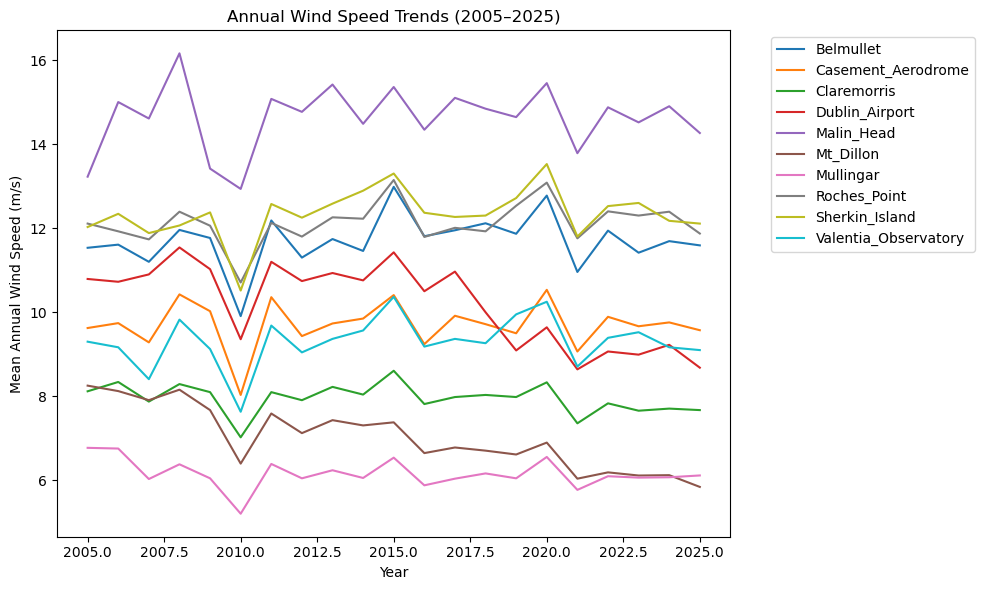

In [ ]:
# Mean annual wind speed per station
annual_trend = (
    df.groupby(["station", "year"])["wdsp"]
      .mean()
      .reset_index()
)

# Plot trends
plt.figure(figsize=(10,6))
for station in annual_trend["station"].unique():
    subset = annual_trend[annual_trend["station"] == station]
    plt.plot(subset["year"], subset["wdsp"], label=station)

plt.xlabel("Year")
plt.ylabel("Mean Annual Wind Speed (m/s)")
plt.title("Annual Wind Speed Trends (2005–2025)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Monthly Seasonal Wind Pattern and Variability per Station

In [20]:
# Compute monthly means for each station (seasonal pattern)
monthly_pattern = df.groupby(["station", "month"])["wdsp"].mean().reset_index()

# Compute standard deviation per month to see variability
monthly_std = df.groupby(["station", "month"])["wdsp"].std().reset_index()
monthly_std.rename(columns={"wdsp": "std_wdsp"}, inplace=True)

# Merge mean + std
pattern = monthly_pattern.merge(monthly_std, on=["station", "month"])
pattern.head(12)


,station,month,wdsp,std_wdsp
0,Belmullet,1,13.595238,2.344243
1,Belmullet,2,13.080952,2.571112
2,Belmullet,3,12.090476,1.524764
3,Belmullet,4,10.704762,1.028823
4,Belmullet,5,11.066667,1.892441
5,Belmullet,6,10.480952,1.322354
6,Belmullet,7,9.776190,1.232439
7,Belmullet,8,10.765000,1.497814
8,Belmullet,9,11.075000,1.917750
9,Belmullet,10,12.110000,1.841024


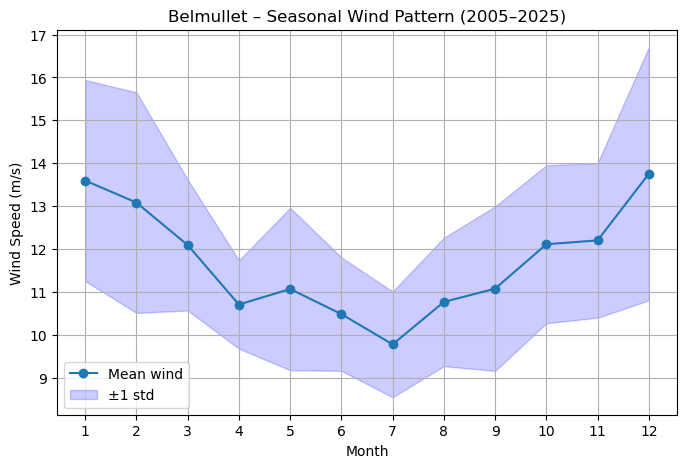

In [ ]:
# Visualize seasonal pattern with variability for Belmullet
station_name = "Belmullet"
subset = pattern[pattern["station"] == station_name]

plt.figure(figsize=(8,5))
plt.plot(subset["month"], subset["wdsp"], marker='o', label="Mean wind")
plt.fill_between(subset["month"], 
                 subset["wdsp"] - subset["std_wdsp"], 
                 subset["wdsp"] + subset["std_wdsp"], 
                 color='blue', alpha=0.2, label="±1 std")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Belmullet – Seasonal Wind Pattern (2005–2025)")
plt.legend()
plt.grid(True)
plt.show()
